In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Read in processed data
df = pd.read_csv('./data/data_processed.csv')
df.head()

,race,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,pt_lab_procedure_tot,pt_procedure_tot,pt_med_tot,pt_outp_tot,pt_inp_tot,pt_ER_tot,pt_diag_tot,past_readmits_lt30,past_readmits_gt30,past_readmits_none
0,Caucasian,0,1,41,0,1,0,0,0,1,...,41,0,1,0,0,0,1,0,0,1
1,Caucasian,1,3,59,0,18,0,0,0,9,...,59,0,18,0,0,0,9,0,1,0
2,AfricanAmerican,2,2,11,5,13,2,0,1,6,...,11,5,13,2,1,0,6,0,0,1
3,Caucasian,3,2,44,1,16,0,0,0,7,...,44,1,16,0,0,0,7,0,0,1
4,Caucasian,4,1,51,0,8,0,0,0,5,...,51,0,8,0,0,0,5,0,0,1


In [16]:
# Check the target column
print(df['readmitted'])
print('readmitted is column number ', df.columns.get_loc('readmitted'))

0         NO
1        >30
2         NO
3         NO
4         NO
        ... 
97103    >30
97104     NO
97105     NO
97106     NO
97107     NO
Name: readmitted, Length: 97108, dtype: object
readmitted is column number  20


Our initial goal was to predict for 30 day hospital readmissions, so we combine the values 'NO' and '>30' in the column 'readmitted' and relabel the value with the integer 0.
This is because there is no readmission for the patient in less than 30 days.

The value '<30' has been relabeled with the integer 1.

In [17]:
df.loc[df['readmitted'] == 'NO', 'readmitted'] = int(0)
#df.loc[df['readmitted'] == '>30', 'readmitted'] = int(0)
df.loc[(df['readmitted'] == '<30') | (df['readmitted'] == '>30'), 'readmitted'] = int(1)

# Make sure column values are integers, necessary for classification algorithms later
df['readmitted'] = df['readmitted'].astype('int')
print(df['readmitted'].dtype)

int64


In [18]:
# List all columns in dataset
df.columns 

Index(['race', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'diabetesMed',
       'readmitted', 'admission_urg_ind', 'admission_nurg_ind',
       'admission_none_ind', 'discharge_shortterm_ind',
       'discharge_longterm_ind', 'discharge_none_ind', 'admission_source_1',
       'admission_source_2', 'admission_source_3', 'caucasian_ind',
       'africanamerican_ind', 'hispanic_ind', 'asian_ind', 'otherrace_ind',
       'female_ind', 'male_ind', 'readmit_diag_1', 'readmit_diag_2',
       'readmit_diag_3', 'readmit_diag_4', 'readmit_diag_5', 'readmit_diag_6',
       'readmit_diag_7', 'readmit_diag_8', 'readmit_diag_9', 'readmit_diag_10',
       'readmit_diag_11', 'readmit_diag_12', 'readmit_diag_13',
       'pt_ris

In [19]:
# Single out which columns will be usede to predict readmit rate
features = ['age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'diabetesMed',
       'admission_urg_ind', 'admission_nurg_ind',
       'admission_none_ind', 'discharge_shortterm_ind',
       'discharge_longterm_ind', 'discharge_none_ind', 'admission_source_1',
       'admission_source_2', 'admission_source_3', 'caucasian_ind',
       'africanamerican_ind', 'hispanic_ind', 'asian_ind', 'otherrace_ind',
       'female_ind', 'male_ind', 'readmit_diag_1', 'readmit_diag_2',
       'readmit_diag_3', 'readmit_diag_4', 'readmit_diag_5', 'readmit_diag_6',
       'readmit_diag_7', 'readmit_diag_8', 'readmit_diag_9', 'readmit_diag_10',
       'readmit_diag_11', 'readmit_diag_12', 'readmit_diag_13',
       'pt_risk_diag_ct', 'pt_diag_ct', 'd_external_index',
       'd_supplementary_index', 'd_infect_ind', 'd_neoplasm_ind',
       'd_endocrine_ind', 'd_blood_ind', 'd_mental_ind', 'd_nervous_ind',
       'd_circulatory_ind', 'd_respiratory_ind', 'd_digestive_ind',
       'd_genitourinary_ind', 'd_pegnancy_ind', 'd_skin_ind', 'd_musculo_ind',
       'd_congenital_ind', 'd_perinatal_ind', 'd_symptoms_ind', 'd_injury_ind',
       'dia_med_change_ind', 'dia_med_nochange_ind', 'pt_admission_urg_ct',
       'admission_nurg_ct', 'admission_none_ct', 'pt_discharge_shortterm_ct',
       'pt_discharge_longterm_ct', 'pt_discharge_none_ct',
       'pt_admission_source_1_ct', 'pt_admission_source_2_ct',
       'pt_admission_source_3_ct', 'pt_time_tot', 'pt_lab_procedure_tot',
       'pt_procedure_tot', 'pt_med_tot', 'pt_outp_tot', 'pt_inp_tot',
       'pt_ER_tot', 'pt_diag_tot', 'past_readmits_lt30', 'past_readmits_gt30',
       'past_readmits_none']


In [20]:
from sklearn.model_selection import train_test_split

#Creating an additional column to stratify over 2 variables
df['strat_col'] = df['race'].astype(str) + "_" + df['readmitted'].astype(str)
train, test = train_test_split(df, test_size=.2, stratify=df['strat_col'], random_state=42)
train = train.drop(columns=['race','strat_col'])
test = test.drop(columns=['race','strat_col'])

We first use knn classification. On the training data, we perform a 5-fold split, and compute the accuracy and confusion matrices for the model at each split.

For knn, we begin with the hyperparameter 15.

In [21]:
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

n_splits = 5
current_split = 0
metrics={n:[] for n in range(0,n_splits)}

pipe = Pipeline([('scale', MinMaxScaler()), ('knn', KNeighborsClassifier(15))])

kfold = KFold(n_splits, shuffle = True)

for s_train, s_test in kfold.split(train):

    train_features = train.iloc[s_train][features]
    test_features = train.iloc[s_test][features]

    train_target = train.iloc[s_train]['readmitted']
    test_target = train.iloc[s_test]['readmitted']

    pipe.fit(train_features,train_target)
    metrics[current_split].append(accuracy_score(pipe.predict(test_features), test_target))
    metrics[current_split].append(confusion_matrix(pipe.predict(test_features), test_target))

    #probs = pipe.predict_proba(test_features)
    y_pred = pipe.predict(test_features)

    false_pos_rate, true_pos_rate, threshold = roc_curve(test_target, y_pred)

    #PRINTING ROC HERE
    print(auc(false_pos_rate, true_pos_rate))

    current_split += 1

for k in range(0,4):
    print('The accuracy of split ', k, ' is ', metrics[k][0], ' confusion is ', metrics[k][1])


0.6758896548143835
0.6795432985562456
0.6822857768139388
0.6708722014715865
0.680447360058258
The accuracy of split  0  is  0.6816836143647831  confusion is  [[6597 3451]
 [1495 3995]]
The accuracy of split  1  is  0.6872626633198172  confusion is  [[6723 3388]
 [1471 3955]]
The accuracy of split  2  is  0.6901589753491665  confusion is  [[6732 3332]
 [1482 3991]]
The accuracy of split  3  is  0.6794748020853446  confusion is  [[6666 3387]
 [1593 3891]]


Now we cross-validate to see if we can choose a better hyperparameter for imporving accuracy. For the kfold, we still do 5 splits.

From the results, it seems unlikey accuracy can be imporved beyond about 88% just by varying the hyperparametter.

In [22]:
%%time

n_splits = 5
kfold = KFold(n_splits, shuffle = True)

ave_accuracies = {k:[] for k in range(1,21)}

for k in range(1,21):

    pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(15))])
    accuracy = [] #Holds accuracy of model at each split, to be averaged later

    for s_train, s_test in kfold.split(train):

        train_features = train.iloc[s_train][features]
        test_features = train.iloc[s_test][features]

        train_target = train.iloc[s_train]['readmitted']
        test_target = train.iloc[s_test]['readmitted']

        pipe.fit(train_features, train_target)
        accuracy.append(accuracy_score(pipe.predict(test_features), test_target))

    ave_accuracies[k].append(sum(accuracy)/len(accuracy))
   

for k in ave_accuracies:
    print('When the knn parameter k is ', k, ', the average accuracy among the splits is ', ave_accuracies[k][0])


When the knn parameter k is  1 , the average accuracy among the splits is  0.7861519509982163
When the knn parameter k is  2 , the average accuracy among the splits is  0.7857400443203963
When the knn parameter k is  3 , the average accuracy among the splits is  0.7864351840610209
When the knn parameter k is  4 , the average accuracy among the splits is  0.7873490941321334
When the knn parameter k is  5 , the average accuracy among the splits is  0.786550995948013
When the knn parameter k is  6 , the average accuracy among the splits is  0.7875164299773187
When the knn parameter k is  7 , the average accuracy among the splits is  0.7863450566927989
When the knn parameter k is  8 , the average accuracy among the splits is  0.7858044324919709
When the knn parameter k is  9 , the average accuracy among the splits is  0.786525231069332
When the knn parameter k is  10 , the average accuracy among the splits is  0.785752910190683
When the knn parameter k is  11 , the average accuracy among t

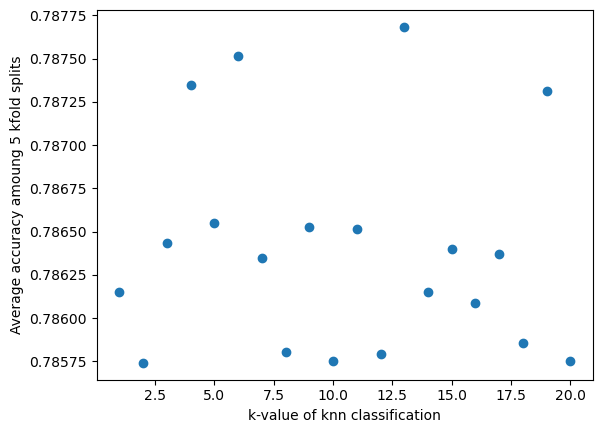

In [24]:
k_values = [n for n in range(1,21)]
acc = [ave_accuracies[n][0] for n in range(1,21)]
plt.scatter(k_values, acc)
plt.xlabel('k-value of knn classification')
plt.ylabel('Average accuracy amoung 5 kfold splits')
plt.show()
#I left this in for now, but with so little change in accuracy among different hyperparameter choices, this should probably be taken out.

Now we use xgboost to classify the readmits. We still use 5 splits in kfold.

We measure performance by computing accuracy and confusion matrix. By these metrics, xgboost is very simmilar to knn.

In [25]:
import xgboost as xgb

xgb_class = xgb.XGBClassifier(eval_metric='logloss')

n_splits = 5
current_split = 0
boost_metrics={n:[] for n in range(0,n_splits)}

for s_train, s_test in kfold.split(train):

    train_features = train.iloc[s_train][features]
    test_features = train.iloc[s_test][features]

    train_target = train.iloc[s_train]['readmitted']
    test_target = train.iloc[s_test]['readmitted']

    xgb_class.fit(train_features, train_target)
    boost_metrics[current_split].append(accuracy_score(xgb_class.predict(test_features), test_target))
    boost_metrics[current_split].append(confusion_matrix(xgb_class.predict(test_features), test_target))
    current_split += 1

    probs = pipe.predict_proba(test_features)
    y_pred = (probs[:,1]>=0.12)

    false_pos_rate, true_pos_rate, threshold = roc_curve(test_target, y_pred)
    print(auc(false_pos_rate, true_pos_rate))

for k in range(0,4):
    print('The accuracy of split ', k, ' is ', boost_metrics[k][0], ' confusion is ', boost_metrics[k][1])


0.6184695377809151
0.6230427314478207
0.6316498928619658
0.6285689561213912
0.6249028845516917
The accuracy of split  0  is  0.9613206332861373  confusion is  [[7819  230]
 [ 371 7118]]
The accuracy of split  1  is  0.9658235180536783  confusion is  [[7984  232]
 [ 299 7022]]
The accuracy of split  2  is  0.9646649932419386  confusion is  [[7754  215]
 [ 334 7234]]
The accuracy of split  3  is  0.962927206024329  confusion is  [[7760  189]
 [ 387 7201]]
